#### General Model Framework
* Jump component is insufficient to completely model the volatility surface
* Stochastic volatility is required as well as stochastic interest rate component
* Bakshi-Cao-Chen market model is characterized by stochastic volatility, jump risk, stochastic short rates

#### 9.3 Features of the model
* Statistical properties: can replicate features of index and interest rate to be modeled
* Price replication: Able to reproduce vanilla options
* Degrees of Freedom: need sufficient number of parameters to calibrate to, prices, implied vol, interest rates

#### 9.4 Zero Coupon Bond Valuation
* Discount factor $B_0(T)$ for discounting cash flows due at time T to time t=0. 
* This value has to be modeled as well since it is uncertain

#### 9.5 European Option Valuation
* PDE Approach: solve a pde that derivative asset must satisfy given dynamics of underlying asset
* Fourier-based: Semi-analytical pricing (Integrals) for derivative assets
* Monte Carlo Simulation: 
    * Discretize the risk-netural process, 
    * Use pseudo random numbers to reproduce asset price evolution and the derivative asset under consideration
    * Run lots of iterations 
    * Discount maturity/exercise prices to time t
    * Average over all option values at a given time period t 
* Monte Carlo is flexible but slow and most applicable for complex products
* Transform and PDE is best for vanilla options

#### Chapter 10: Monte Carlo Simulation

* Millions of computations needed to price one option
* Imagine simulation with 100 time steps and 100,000 simulated paths with constant vol and short rate
* You need 10,000,000 random numbers
* You need to estimate 100 OLS regressions over 100k pairs of numbers
* You need to discount 100k numbers at 100 time steps
* If your volatility and short rate become stochastic your model becomes computationally infeasible


In [1]:
#
# Valuation of Zero-Coupon Bonds
# in Cox-Ingersoll-Ross (1985) Model
# 09_gmm/CIR_zcb_valuation_gen.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import numpy as np

#
# Example Parameters CIR85 Model
#
r0, kappa_r, theta_r, sigma_r, t, T = 0.04, 0.3, 0.04, 0.1, 0.5, 5.0

#
# Zero-Coupon Bond Valuation Formula
#


def gamma(kappa_r, sigma_r):
    ''' Help Function. '''
    return np.sqrt(kappa_r ** 2 + 2 * sigma_r ** 2)


def b1(alpha):
    ''' Help Function. '''
    r0, kappa_r, theta_r, sigma_r, t, T = alpha
    g = gamma(kappa_r, sigma_r)
    return (((2 * g * np.exp((kappa_r + g) * (T - t) / 2)) /
             (2 * g + (kappa_r + g) * (np.exp(g * (T - t)) - 1))) **
            (2 * kappa_r * theta_r / sigma_r ** 2))


def b2(alpha):
    ''' Help Function. '''
    r0, kappa_r, theta_r, sigma_r, t, T = alpha
    g = gamma(kappa_r, sigma_r)
    return ((2 * (np.exp(g * (T - t)) - 1)) /
            (2 * g + (kappa_r + g) * (np.exp(g * (T - t)) - 1)))


def B(alpha):
    ''' Function to value unit zero-coupon bonds in CIR85 Model.

    Parameters
    ==========
    r0: float
        initial short rate
    kappa_r: float
        mean-reversion factor
    theta_r: float
        long-run mean of short rate
    sigma_r: float
        volatility of short rate
    t: float
        valuation date
    T: float
        time horizon/interval

    Returns
    =======
    zcb_value: float
        value of zero-coupon bond
    '''
    b_1 = b1(alpha)
    b_2 = b2(alpha)
    r0, kappa_r, theta_r, sigma_r, t, T = alpha
    # expected value of r_t
    E_rt = theta_r + np.exp(-kappa_r * t) * (r0 - theta_r)
    zcb_value = b_1 * np.exp(-b_2 * E_rt)
    return zcb_value


if __name__ == '__main__':
    #
    # Example Valuation
    #
    # discount factor, ZCB value for t & T
    BtT = B([r0, kappa_r, theta_r, sigma_r, t, T])
    print("ZCB Value   %10.4f" % BtT)


ZCB Value       0.8373


In [34]:
#
# Valuation of Zero-Coupon Bonds by Monte Carlo Simulation
# in Cox-Ingersoll-Ross (1985) Model
# 10_mcs/CIR_zcb_simulation.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import math
import numpy as np
# from CIR_zcb_valuation_gen import B
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['font.family'] = 'serif'

#
# Simulation of Square Root Diffusion
#


def CIR_generate_paths(x0, kappa, theta, sigma, T, M, I, x_disc='exact'):
    ''' Function to simulate Square-Root Difussion (SRD/CIR) process.

    Parameters
    ==========
    x0: float
        initial value
    kappa: float
        mean-reversion factor
    theta: float
        long-run mean
    sigma: float
        volatility factor
    T: float
        final date/time horizon
    M: int
        number of time steps
    I: int
        number of paths

    Returns
    =======
    x: NumPy array
        simulated paths
    '''
    dt = T / M
    x = np.zeros((M + 1, I), dtype=np.float)
    x[0] = x0
    xh = np.zeros_like(x)
    xh[0] = x0
    ran = np.random.standard_normal((M + 1, I))

    if x_disc is 'exact':
        # exact discretization
        d = 4 * kappa * theta / sigma ** 2
        c = (sigma ** 2 * (1 - math.exp(-kappa * dt))) / (4 * kappa)
        if d > 1:
            for t in range(1, M + 1):
                l = x[t - 1] * math.exp(-kappa * dt) / c
                chi = np.ramdom.chisquare(d - 1, I)
                x[t] = c * ((ran[t] + np.sqrt(l)) ** 2 + chi)
        else:
            for t in range(1, M + 1):
                l = x[t - 1] * math.exp(-kappa * dt) / c
                N = np.random.poisson(l / 2, I)
                chi = np.random.chisquare(d + 2 * N, I)
                x[t] = c * chi

    else:
        # Euler scheme (full truncation)
        for t in range(1, M + 1):
            xh[t] = (xh[t - 1] + kappa * (theta - np.maximum(0, xh[t - 1])) *
                     dt + np.sqrt(np.maximum(0, xh[t - 1])) *
                     sigma * ran[t] * math.sqrt(dt))
            x[t] = np.maximum(0, xh[t])
    return x


#
# Graphical Output of Simulated Paths
#
def plot_paths():
    plt.figure(figsize=(9, 5))
    plt.plot(range(len(r)), r[:, :20])
    plt.xlabel('time step')
    plt.ylabel('short rate')

#
# Valuation of ZCB
#


def zcb_estimator(M=50, x_disc='exact'):
    dt = T / M
    r = CIR_generate_paths(r0, kappa_r, theta_r, sigma_r, T, M, I, x_disc)
    zcb = np.zeros((M + 1, I), dtype=np.float)
    zcb[-1] = 1.0  # final value
    for t in range(M, 0, -1):
        zcb[t - 1] = zcb[t] * np.exp(-(r[t] + r[t - 1]) / 2 * dt)
    return np.sum(zcb, axis=1) / I

#
# Graphical Value Comparison
#


def graphical_comparison(M=50, x_disc='exact'):
    MCS_values = zcb_estimator(M, x_disc)
    CIR_values = []
    dt = T / M
    t_list = np.arange(0.0, T + 0.001, dt)  # dates of interest
    for t in t_list:
        alpha = r0, kappa_r, theta_r, sigma_r, t, T
        CIR_values.append(B(alpha))
        # CIR model values given date list

    fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))
    ax[0].plot(t_list, MCS_values, 'ro', label='MCS values')
    ax[0].plot(t_list, CIR_values, 'b', label='CIR values')
    ax[0].legend(loc=0)
    ax[0].set_ylim(min(CIR_values) - 0.005, max(CIR_values) + 0.005)
    ax[0].set_ylabel('option values')
    ax[0].set_title('maturity $T=2$')
    ax[1].bar(t_list - 0.025 / 2., MCS_values - CIR_values,
              width=0.025)
    plt.ylabel('difference')
    plt.xlim(min(t_list) - 0.1, max(t_list) + 0.1)
    plt.xlabel('time $t$')
    plt.tight_layout()


# if __name__ == '__main__':
    #
    # Model Parameters
    #
r0, kappa_r, theta_r, sigma_r = [0.01, 0.1, 0.03, 0.2]
T = 2.0  # time horizon
M = 50  # time steps
dt = T / M
I = 120# number of MCS paths
np.random.seed(50000)  # seed for RNG

r = CIR_generate_paths(r0, kappa_r, theta_r, sigma_r, T, M, I)


In [14]:
print(opt)

[0.160 0.001 -33.619 4.542]


* Simulate 20 paths for the short rate model with 50 time steps
* The ZCB value is the sum of the short rates divided by the number of paths

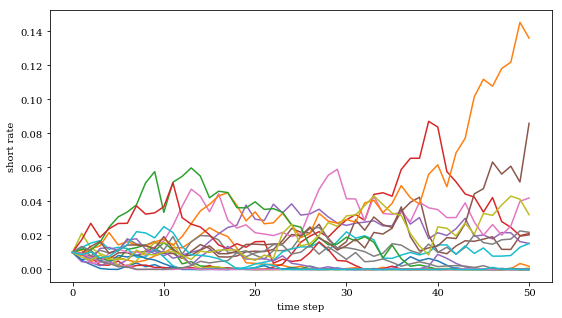

In [35]:
%matplotlib inline
plot_paths()

In [15]:
zcb_estimator(50)

array([ 0.97825231,  0.97864123,  0.97902803,  0.9794189 ,  0.9798123 ,
        0.98020348,  0.98059423,  0.98098483,  0.98137677,  0.98176776,
        0.98215551,  0.98254165,  0.98293143,  0.98332699,  0.98372272,
        0.98411979,  0.98452086,  0.98492327,  0.98532309,  0.98572263,
        0.98612621,  0.98653604,  0.98694859,  0.98735903,  0.98777054,
        0.98818895,  0.98861539,  0.98904499,  0.98947727,  0.98991703,
        0.9903647 ,  0.99081559,  0.9912664 ,  0.99172443,  0.99219437,
        0.99267228,  0.99315336,  0.99363567,  0.99411692,  0.99459844,
        0.99508362,  0.9955663 ,  0.99605014,  0.99653673,  0.9970209 ,
        0.99750428,  0.99798951,  0.99848116,  0.99898157,  0.99948763,  1.        ])

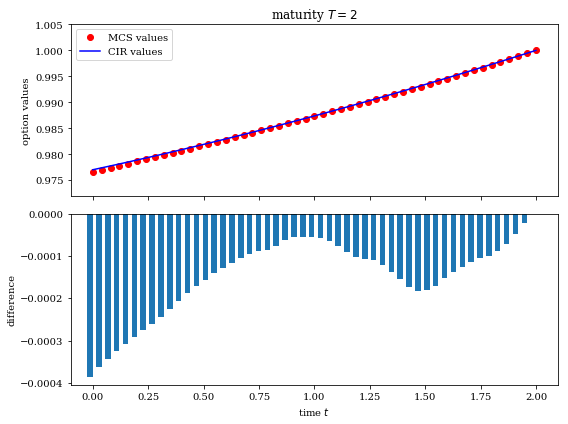

In [32]:
graphical_comparison(50, 'euler')

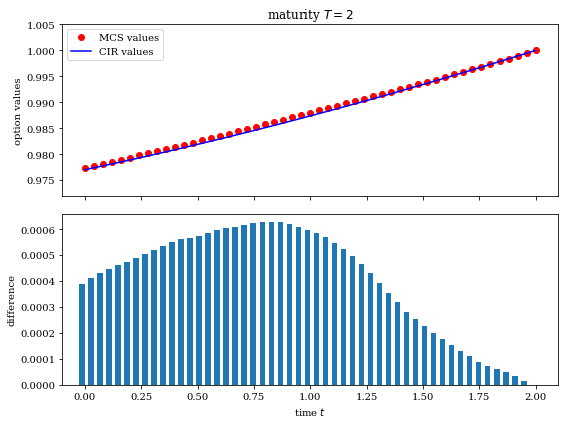

In [33]:
graphical_comparison(50, 'exact')

#### Valuation of European Options
* option: European call and put
* maturities: $T \in$ {1/12, 1, 2}
* strikes: $K \in$ {90, 100, 110} for $S_0$ = 110
* time steps: $M \in$ {25,50} steps per year
* paths: $I \in$ {25000,50000,750000,100000}
* discretization: we combine all schemes (2 for index and 7 for varaince) 14 schemes altogether

* a valuation is accurate if:
    * absolute value difference is smaller than 2.5 cents
    * absolute value difference is less than 1.5%

* moment matching and antithetic paths
    * Antithetic paths are generated with pseudo random numbers $z_{t,i}$ and -$z_{t,i}$
    * moment matching: correct the first two moments of the psuedo-random number 

In [ ]:
#
# Valuation of European Options
# Under Heston (1993) Stochastic Volatility Model
# Comparison of Fourier-based Value and MCS Estimator
# 10_mcs/H93_european_mcs.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import sys
import math
import string
import numpy as np
import pandas as pd
import itertools as it
from datetime import datetime
from time import time
sys.path.append('09_gmm/')
from BCC_option_valuation import H93_call_value

np.set_printoptions(precision=3)

# Fixed Short Rate
r = 0.05

# Heston (1993) Parameters
# from MS (2009), table 3
para = np.array(((0.01, 1.5, 0.15, 0.1),  # panel 1
                 # (v0,kappa_v,sigma_v,rho)
                 (0.04, 0.75, 0.3, 0.1),  # panel 2
                 (0.04, 1.50, 0.3, 0.1),  # panel 3
                 (0.04, 1.5, 0.15, -0.5)))  # panel 4

theta_v = 0.02  # long-term variance level
S0 = 100.0  # initial index level

# General Simulation Parameters
write = True
verbose = False
option_types = ['CALL', 'PUT']  # option types
steps_list = [25, 50]  # time steps p.a.
paths_list = [25000, 50000, 75000, 100000]   # number of paths per valuation

s_disc_list = ['Log', 'Naive']  # Euler scheme: log vs. naive
# discretization schemes for SRD process
x_disc_list = ['Full Truncation', 'Partial Truncation', 'Truncation',
               'Absorption', 'Reflection', 'Higham-Mao', 'Simple Reflection']

# antithetic paths for variance reduction
anti_paths = [False, True]
# random number correction (std + mean + drift)
moment_matching = [False, True]

t_list = [1.0 / 12, 1.0, 2.0]  # maturity list
k_list = [90, 100, 110]      # strike list
PY1 = 0.025  # performance yardstick 1: abs. error in currency units
PY2 = 0.015  # performance yardstick 2: rel. error in decimals
runs = 5  # number of simulation runs
np.random.seed(250000)  # set RNG seed value

#
# Function for Short Rate and Volatility Processes
#


def SRD_generate_paths(x_disc, x0, kappa, theta, sigma,
                       T, M, I, rand, row, cho_matrix):
    ''' Function to simulate Square-Root Difussion (SRD/CIR) process.

    Parameters
    ==========
    x0: float
        initial value
    kappa: float
        mean-reversion factor
    theta: float
        long-run mean
    sigma: float
        volatility factor
    T: float
        final date/time horizon
    M: int
        number of time steps
    I: int
        number of paths
    row: int
        row number for random numbers
    cho_matrix: NumPy array
        cholesky matrix

    Returns
    =======
    x: NumPy array
        simulated variance paths
    '''
    dt = T / M
    x = np.zeros((M + 1, I), dtype=np.float)
    x[0] = x0
    xh = np.zeros_like(x)
    xh[0] = x0
    sdt = math.sqrt(dt)
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        if x_disc == 'Full Truncation':
            xh[t] = (xh[t - 1] + kappa * (theta -
                                          np.maximum(0, xh[t - 1])) * dt +
                     np.sqrt(np.maximum(0, xh[t - 1])) *
                     sigma * ran[row] * sdt)
            x[t] = np.maximum(0, xh[t])
        elif x_disc == 'Partial Truncation':
            xh[t] = (xh[t - 1] + kappa * (theta - xh[t - 1]) * dt +
                     np.sqrt(np.maximum(0, xh[t - 1])) *
                     sigma * ran[row] * sdt)
            x[t] = np.maximum(0, xh[t])
        elif x_disc == 'Truncation':
            x[t] = np.maximum(0, x[t - 1] +
                              kappa * (theta - x[t - 1]) * dt +
                              np.sqrt(x[t - 1]) * sigma * ran[row] * sdt)
        elif x_disc == 'Reflection':
            xh[t] = (xh[t - 1] +
                     kappa * (theta - abs(xh[t - 1])) * dt +
                     np.sqrt(abs(xh[t - 1])) * sigma * ran[row] * sdt)
            x[t] = abs(xh[t])
        elif x_disc == 'Higham-Mao':
            xh[t] = (xh[t - 1] + kappa * (theta - xh[t - 1]) * dt +
                     np.sqrt(abs(xh[t - 1])) * sigma * ran[row] * sdt)
            x[t] = abs(xh[t])
        elif x_disc == 'Simple Reflection':
            x[t] = abs(x[t - 1] + kappa * (theta - x[t - 1]) * dt +
                       np.sqrt(x[t - 1]) * sigma * ran[row] * sdt)
        elif x_disc == 'Absorption':
            xh[t] = (np.maximum(0, xh[t - 1]) +
                     kappa * (theta - np.maximum(0, xh[t - 1])) * dt +
                     np.sqrt(np.maximum(0, xh[t - 1])) *
                     sigma * ran[row] * sdt)
            x[t] = np.maximum(0, xh[t])
        else:
            print(x_disc)
            print("No valid Euler scheme.")
            sys.exit(0)
    return x

#
# Function for Heston Index Process
#


def H93_generate_paths(S0, r, v, row, cho_matrix):
    ''' Simulation of Heston (1993) index process.

    Parameters
    ==========
    S0: float
        initial value
    r: float
        constant short rate
    v: NumPy array
        simulated variance paths
    row: int
        row/matrix of random number array to use
    cho_matrix: NumPy array
        Cholesky matrix

    Returns
    =======
    S: NumPy array
        simulated index level paths
    '''
    S = np.zeros((M + 1, I), dtype=np.float)
    S[0] = S0
    bias = 0.0
    sdt = math.sqrt(dt)
    for t in range(1, M + 1, 1):
        ran = np.dot(cho_matrix, rand[:, t])
        if momatch:
            bias = np.mean(np.sqrt(v[t]) * ran[row] * sdt)
        if s_disc == 'Log':
            S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt +
                                     np.sqrt(v[t]) * ran[row] * sdt - bias)
        elif s_disc == 'Naive':
            S[t] = S[t - 1] * (math.exp(r * dt) +
                               np.sqrt(v[t]) * ran[row] * sdt - bias)
        else:
            print("No valid Euler scheme.")
            exit(0)
    return S


def random_number_generator(M, I):
    ''' Function to generate pseudo-random numbers.

    Parameters
    ==========
    M: int
        time steps
    I: int
        number of simulation paths

    Returns
    =======
    rand: NumPy array
        random number array
    '''
    if antipath:
        rand = np.random.standard_normal((2, M + 1, int(I / 2)))
        rand = np.concatenate((rand, -rand), 2)
    else:
        rand = np.random.standard_normal((2, M + 1, I))
    if momatch:
        rand = rand / np.std(rand)
        rand = rand - np.mean(rand)
    return rand

#
# Valuation
#


t0 = time()

results = pd.DataFrame()

tmpl_1 = '%4s | %3s | %6s | %6s | %6s | %6s | %5s | %5s' \
    % ('T', 'K', 'V0', 'V0_MCS', 'err', 'rerr', 'acc1', 'acc2')
tmpl_2 = '%4.3f | %3d | %6.3f | %6.3f | %6.3f | %6.3f | %5s | %5s'

if __name__ == '__main__':

    for alpha in it.product(option_types, steps_list, paths_list, s_disc_list,
                            x_disc_list, anti_paths, moment_matching):
        print('\n\n', alpha, '\n')
        option, M0, I, s_disc, x_disc, antipath, momatch = alpha
        for run in range(runs):
            for panel in range(4):
                # Correlation Matrix
                v0, kappa_v, sigma_v, rho = para[panel]
                covariance_matrix = np.zeros((2, 2), dtype=np.float)
                covariance_matrix[0] = [1.0, rho]
                covariance_matrix[1] = [rho, 1.0]
                cho_matrix = np.linalg.cholesky(covariance_matrix)
                if verbose:
                    print("\nResults for Panel %d\n" % (panel + 1))
                    print(tmpl_1)
                for T in t_list:  # maturity list
                    # memory clean-up
                    v, S, rand, h = 0.0, 0.0, 0.0, 0.0
                    M = int(M0 * T)  # number of total time steps
                    dt = T / M  # time interval in years
                    # random numbers
                    rand = random_number_generator(M, I)
                    # volatility process paths
                    v = SRD_generate_paths(x_disc, v0, kappa_v, theta_v,
                                           sigma_v, T, M, I, rand, 1,
                                           cho_matrix)
                    # index level process paths
                    S = H93_generate_paths(S0, r, v, 0, cho_matrix)
                    for K in k_list:
                        # European option values
                        B0T = math.exp(-r * T)  # discount factor
                        # European call option value (semi-analytical)
                        C0 = H93_call_value(S0, K, T, r, kappa_v,
                                            theta_v, sigma_v, rho, v0)
                        P0 = C0 + K * B0T - S0
                        if option is 'PUT':
                            # benchmark value
                            V0 = P0
                            # inner value matrix put
                            h = np.maximum(K - S, 0)
                        elif option is 'CALL':
                            # benchmark value
                            V0 = C0
                            # inner value matrix call
                            h = np.maximum(S - K, 0)
                        else:
                            print("No valid option type.")
                            sys.exit(0)
                        pv = B0T * h[-1]  # present value vector
                        V0_MCS = np.sum(pv) / I   # MCS estimator
                        SE = np.std(pv) / math.sqrt(I)
                        # standard error
                        error = V0_MCS - V0
                        rel_error = (V0_MCS - V0) / V0
                        PY1_acc = abs(error) < PY1
                        PY2_acc = abs(rel_error) < PY2
                        res = pd.DataFrame({'timestamp': datetime.now(),
                                'otype': option, 'runs': runs, 'steps': M0,
                                'paths': I, 'index_disc': s_disc,
                                'var_disc': x_disc, 'anti_paths': antipath,
                                'moment_matching': momatch, 'panel': panel,
                                'maturity': T, 'strike': K, 'value': V0,
                                'MCS_est': V0_MCS, 'SE': SE, 'error': error,
                                'rel_error': rel_error, 'PY1': PY1, 'PY2': PY2,
                                'PY1_acc': PY1_acc, 'PY2_acc': PY2_acc,
                                'PY_acc': PY1_acc or PY2_acc},
                               index=[0, ])

                        if verbose:
                            print(tmpl_2 % (T, K, V0, V0_MCS, error,
                                            rel_error, PY1_acc, PY2_acc))

                        results = results.append(res, ignore_index=True)

    if write:
        d = str(datetime.now().replace(microsecond=0))
        d = d.replace('-', '_').replace(' ', '_').replace(':', '_')
        h5 = pd.HDFStore('10_mcs/mcs_european_%s.h5' % d, 'w')
        h5['results'] = results
        h5.close()

    print("Total time in minutes %8.2f" % ((time() - t0) / 60))




 ('CALL', 25, 25000, 'Log', 'Full Truncation', False, False) 



 ('CALL', 25, 25000, 'Log', 'Full Truncation', False, True) 



 ('CALL', 25, 25000, 'Log', 'Full Truncation', True, False) 



 ('CALL', 25, 25000, 'Log', 'Full Truncation', True, True) 



 ('CALL', 25, 25000, 'Log', 'Partial Truncation', False, False) 



 ('CALL', 25, 25000, 'Log', 'Partial Truncation', False, True) 



 ('CALL', 25, 25000, 'Log', 'Partial Truncation', True, False) 



 ('CALL', 25, 25000, 'Log', 'Partial Truncation', True, True) 



 ('CALL', 25, 25000, 'Log', 'Truncation', False, False) 



 ('CALL', 25, 25000, 'Log', 'Truncation', False, True) 



 ('CALL', 25, 25000, 'Log', 'Truncation', True, False) 



 ('CALL', 25, 25000, 'Log', 'Truncation', True, True) 



 ('CALL', 25, 25000, 'Log', 'Absorption', False, False) 



 ('CALL', 25, 25000, 'Log', 'Absorption', False, True) 



 ('CALL', 25, 25000, 'Log', 'Absorption', True, False) 



 ('CALL', 25, 25000, 'Log', 'Absorption', True, True) 



 (